In [1]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms

import torch.utils.data
import torch.backends.cudnn as cudnn
from torchvision import datasets, transforms
from torchvision.utils import save_image
import os
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F

%matplotlib inline

In [2]:
data_dir = "./data/autoencoder_db/"


loader = transforms.Compose([transforms.ToTensor()])

train_data = datasets.ImageFolder(data_dir + 'train', transform=loader)
valid_data = datasets.ImageFolder(data_dir + 'valid', transform=loader)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=64)

unloader = transforms.ToPILImage()

# Save Image Function

In [3]:
def save_im(tensor, title):
    image = tensor.cpu().clone()
    x = image.clamp(0, 255)
    x = x.view(x.size(0), 3, 96, 96)
    save_image(x, "./generated_data_vae/ezperiment_13_0.7_mean_mse/image_{}.png".format(title))

# Variational Auto Encoder

In [4]:
ngf = 64
ndf = 64
nc = 3
nz = 100

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class VAE(nn.Module):
    def __init__(self, have_cuda):
        super(VAE, self).__init__()

        self.have_cuda = have_cuda

        self.encoder = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, 1024, 4, 1, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            Flatten()
        )

        self.decoder = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(1024, ngf * 8, 8, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 3, 3, 0, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, nc, 4, 2, 1, bias=False),
            nn.Sigmoid()
        )
        
        # Change input size in fc1 to your flattened output
        self.fc1 = nn.Linear(82944, 512)
        
        self.fc21 = nn.Linear(512, nz)
        self.fc22 = nn.Linear(512, nz)

        self.fc3 = nn.Linear(nz, 512)
        self.fc4 = nn.Linear(512, 1024)

        self.lrelu = nn.LeakyReLU()
        self.relu = nn.ReLU()

    def encode(self, x):
        conv = self.encoder(x)
        h1 = self.fc1(conv)
        return self.fc21(h1), self.fc22(h1)

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        deconv_input = self.fc4(h3)
        deconv_input = deconv_input.view(-1,1024,1,1)
        return self.decoder(deconv_input)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if self.have_cuda:
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        decoded = self.decode(z)
        return decoded, mu, logvar

In [5]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    the_loss = BCE + 0.7*KLD
    return the_loss

In [6]:
def validation(model, testloader):
    test_loss = 0
    for data in testloader:
        images, _ = data
        images = images.cuda()
        decoded, mu, logvar = model.forward(images)
        test_loss += loss_function(decoded, images, mu, logvar).item()
    return test_loss

In [7]:
model = VAE(have_cuda=True)
model = model.cuda()

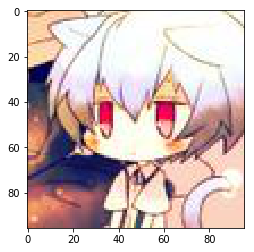

In [8]:
img = unloader(iter(trainloader).next()[0][0])
_ = plt.imshow(img)

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 150

running_loss = 0
steps = 0
print_every = 15
decoded = 0
for epoch in range(num_epochs):
    model.train()
    for data in trainloader:
        steps += 1
        img, _ = data
        img = img.cuda()
        
        decoded, mu, logvar = model(img)
        loss = loss_function(decoded, img, mu, logvar)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if steps % print_every == 0:
            model.eval()

            with torch.no_grad():
                valid_loss = validation(model, validloader)
            
            model.train()
            
            print("Epoch: {}/{}.. ".format(epoch+1, num_epochs),
                  "Training Loss: {:.4f}.. ".format(running_loss/print_every),
                  "valid Loss: {:.4f}.. ".format(valid_loss/len(validloader)))
            running_loss = 0
    if epoch % 10 == 0:
        save_im(decoded, 'epoch '+str(epoch))

Epoch: 1/150..  Training Loss: 217964.8813..  valid Loss: 181494.4062.. 
Epoch: 1/150..  Training Loss: 149520.9062..  valid Loss: 152079.2457.. 
Epoch: 1/150..  Training Loss: 127783.3823..  valid Loss: 133278.4396.. 
Epoch: 1/150..  Training Loss: 118445.7948..  valid Loss: 132465.2109.. 
Epoch: 1/150..  Training Loss: 106301.0911..  valid Loss: 122612.9815.. 
Epoch: 2/150..  Training Loss: 92870.6986..  valid Loss: 102514.9261.. 
Epoch: 2/150..  Training Loss: 93519.0344..  valid Loss: 93002.5845.. 
Epoch: 2/150..  Training Loss: 89578.0714..  valid Loss: 88943.0817.. 
Epoch: 2/150..  Training Loss: 85593.9083..  valid Loss: 84134.9062.. 
Epoch: 2/150..  Training Loss: 84172.1687..  valid Loss: 80617.1676.. 
Epoch: 2/150..  Training Loss: 78109.1703..  valid Loss: 77153.0277.. 
Epoch: 3/150..  Training Loss: 72755.7490..  valid Loss: 74627.6864.. 
Epoch: 3/150..  Training Loss: 72491.1031..  valid Loss: 72754.6374.. 
Epoch: 3/150..  Training Loss: 70649.5964..  valid Loss: 71039.660

In [10]:
torch.save({'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': running_loss/print_every,
            'val_loss': valid_loss/len(validloader)
            }, "./generated_data_vae/ezperiment_13_0.7_mean_mse/model_{}_{}.pkl".format(epoch, steps))

In [11]:
test_data = datasets.ImageFolder(data_dir + 'test', transform=loader)
testloader = torch.utils.data.DataLoader(valid_data, batch_size=256)

img, _ = iter(testloader).next()

model.eval()
with torch.no_grad():
    output = model.forward(img.cuda())
    save_im(output[0], 'test_output')